Introduction to GPU Programming Summer School
========================

D. Quigley, University of Warwick

---

# Tutorial 3: Memory


#### You can reasonably consider the material in this session to be "advanced". We'll be taking the acceleration we get from a GPU and optimising how memroy is used to get even better speedups.

* #### So far we've only explicitly managed device arrays which live in *global memory* - the several GB of RAM on the device

* #### We've implicitly used *local memory* - stack variables created automatically for each instance of a kernel, e.g. the loop counters in our Mandelbrot example

* #### Global memory is large (relatively speaking) but not "on-chip". Reads and writes from/to global memory are slow compared to operating on data already in the multiprocessor registers

* #### *Shared memory* is a small quantity of read/write on-chip memory shared by all threads in a block. It can be used as a cache, but the programmer must code for this

* #### *Constant memory* is a set by the host, and is read only on the device. It is automatically cached on-chip and so can be used to speed up access to commonly used data

* #### Both constant memory and shared memory have size limits which depend on the device and its compute cabability


## Shared memory

Import what we'll need for this example.

In [1]:
import numpy as np                 # Numpy
from numba import cuda, float64    # Cuda and numba float64 datatype

import matplotlib.pyplot as plt    # Matplotlib
%matplotlib inline                 

from timeit import default_timer as timer  # Timer

Consider the following kernel. This evolves a point on a 2D grid forward in time according to a simple finite-difference scheme for numerically solving the diffusion equation.

$$ U^{n+1}_{i,j} = U^{n}_{i,j} + D \delta t\left[\frac{ U^{n}_{i-1,j} - 2 U^{n}_{i,j} + U^{n}_{i+1,j} }{{\delta x}^2} + \frac{ U^{n}_{i,j-1} - 2 U^{n}_{i,j} + U^{n}_{i,j+1} }{{\delta y}^2} \right] $$

Here $U$ is some function which obeys the diffusion equation, and $D$ is the diffusion coefficient. Grid spacings are  $\delta x$ and $\delta y$ and time is evolved forward in steps of $\delta t$.

In [2]:
@cuda.jit
def diffusion_kernel(D, invdx2, invdy2, dt, d_u, d_u_new):
    """
    Simple kernel to evolve a function U forward in time according to an explicit FTCS
    finite difference scheme. Arguments are...
    
    D       : Diffusion coefficient
    invdx2  : 1/(dx^2) where dx is the grid spacing in the x direction 
    invdy2  : 1/(dy^2) where dy is the grid spacing in the y direction
    dt      : time step
    d_u     : Device array storing U at the current time step
    d_u_new : Device array storing U at the next time step
    """
    
    # Which row and column on the simulation grid should this thread use
    row = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    col = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    
    # Check that the index lies inside the grid
    if row < d_u.shape[0] and col < d_u.shape[1]:
    
        # Neighbour cells using period boundary conditions
        up   = (row + 1)%d_u.shape[0]
        down = (row - 1)%d_u.shape[0]
    
        left  = (col - 1)%d_u.shape[1]
        right = (col + 1)%d_u.shape[1]
        
        # Compute second derivatives of u w.r.t. x and y
        d2udx2 = (d_u[row,left]  - 2.0*d_u[row,col] + d_u[row,right])*invdx2
        d2udy2 = (d_u[down,col]  - 2.0*d_u[row,col] + d_u[up,col])*invdy2
    
        # Populate u_new with the time-evolved function
        d_u_new[row, col] = d_u[row, col] + D * dt * ( d2udx2 + d2udy2) 

We'll need some parameters/data to play with...

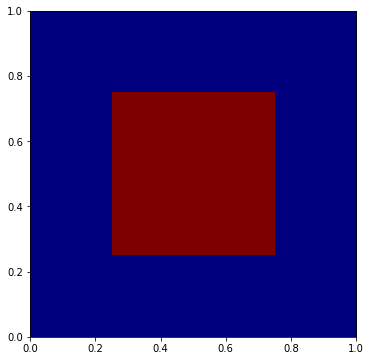

In [49]:
# Create an empty array
dim = 960
c = np.zeros((dim, dim))

# Fill the middle of the grid with a concentration of 1.0
for irow in range(c.shape[0] // 4, 3*c.shape[0] // 4):
    for icol in range(c.shape[1] // 4, 3*c.shape[1] // 4):
        c[irow, icol] = 1.0
        
# We want this to represent a square domain spanning 0 -> 1 in each direction
domain = [0.0, 1.0, 0.0, 1.0]
                                        
D = 1.0  # Diffusion coefficient

x_spacing = 1.0/float(c.shape[0])
y_spacing = 1.0/float(c.shape[1])

# Store spacing as inverse square to avoid repeated division
inv_xspsq = 1.0/(x_spacing**2)
inv_yspsq = 1.0/(y_spacing**2)

# Satisfy stability condition 
time_step = 0.25*min(x_spacing,y_spacing)**2
                
# Plot 
fig = plt.figure(figsize = [6, 6])
plt.imshow(c,cmap='jet',extent=domain);

We've now got everything we need to use `diffusion_kernel` to evolve this initial condition forward in time on the GPU. Let's time this and examine the output. Note that I've been careful here to ensure that the grid size is an exact multiple of the number of threads in a block.

Note also that I have to call ```cuda.synchronise()``` before stopping the timer. In previous examples we've only stopped the timer after making sure the data is available by copying it back to the host, and the copy won't start until all the kernels are finished. Launching of kernels is *asynchronous* - the code will reach the line ```t2 = timer``` after the final time kernels are launched, not when they complete. Since there's no requirement on the data calculated before we reach that statement, we have to block progress until all threads complete manually.

In [50]:
# Copy this array to the device, and create a new device array to hold updated value
d_c = cuda.to_device(c)
d_c_new = cuda.device_array(c.shape, dtype=np.float)

In [52]:
threads_per_block = (32, 32)
blocks_per_grid   = (dim//32, dim//32)

t1 = timer()  # Start timer

# Evolve forward 2000 steps
for step in range(2000):

    # Launch the kernel    
    diffusion_kernel[blocks_per_grid,threads_per_block](D, inv_xspsq, inv_yspsq, time_step, d_c, d_c_new)

    # Swap the identit of the old and new device arrays
    d_c, d_c_new = d_c_new, d_c
    
cuda.synchronize()  # make sure all threads finish before stopping timer
       
t2 = timer()
print("Simulation using simple kernel took : ",1000*(t2-t1)," milliseconds.")

Simulation using simple kernel took :  660.6150440638885  milliseconds.


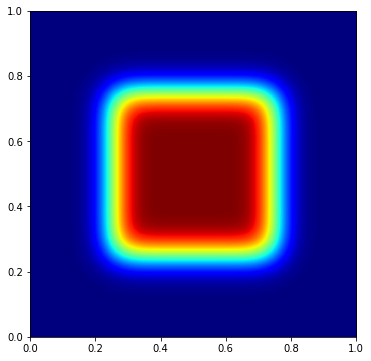

In [53]:
# Copy the current concentration from the device to the host
c = d_c.copy_to_host()

# Display the current concentration profile
fig = plt.figure(figsize = [6, 6])
plt.imshow(c,cmap='jet',extent=[0.0, 1.0, 0.0, 1.0]);

The performance of this kernel is okay, but we can do better.

Consider the part of the kernel which reads from the device array d_u.

```python
        # Compute second derivatives of u w.r.t. x and y
        d2udx2 = (d_u[row,left]  - 2.0*d_u[row,col] + d_u[row,right])*invdx2
        d2udy2 = (d_u[down,col]  - 2.0*d_u[row,col] + d_u[up,col])*invdy2
    
        # Populate u_new with the time-evolved function
        d_u_new[row, col] = d_u[row, col] + D * dt * ( d2udx2 + d2udy2) 
```
Each instance of the kernel (i.e. each thread) needs to load five entries from the array ```d_u``` in device global memory.  Loads from memory are slow compared to compute operations, so there's a good chance these loads account for a significant fraction of the time measured.

We can improve this by recognising that other threads within the same thread block will also need some of these  five entries. If those threads can *share* the data that is loaded from global memory then we'd cut down on the number of loads needed. This is what shared memory is used for - a local (but limited in size) on-chip cache where we can store data which multiple threads within the block will need.

Consider the following kernel. Here threads in blocks of 32 x 32 each load one element from global memory into shared memory. To avoid needing data outside of the shared memory array, only the interior 30 x 30 threads perform computation.

In [54]:
@cuda.jit
def diffusion_kernel_shared(D, invdx2, invdy2, dt, d_u, d_u_new):
    """
    Kernel to evolve a function U forward in time according to an explicit FTCS
    finite difference scheme. Shared memory is used. Arguments are...
    
    D       : Diffusion coefficient
    invdx2  : 1/(dx^2) where dx is the grid spacing in the x direction 
    invdy2  : 1/(dy^2) where dy is the grid spacing in the y direction
    dt      : time step
    d_u     : Device array storing U at the current time step
    d_u_new : Device array storing U at the next time step
    """
    
    # Shared array large enough to store 30x30 block + "halo" of boundary neighbours
    # N.B. the size of the shared array is set at compile time, but see also 
    # https://stackoverflow.com/questions/30510580/numba-cuda-shared-memory-size-at-runtime
    u_sh = cuda.shared.array((32, 32), dtype=float64)
    
    # Row and column in global matrix - 32 x 32 grid including halo
    row = cuda.threadIdx.y + cuda.blockIdx.y * ( cuda.blockDim.y - 2 ) - 1
    col = cuda.threadIdx.x + cuda.blockIdx.x * ( cuda.blockDim.x - 2 ) - 1
    
    # Row and column in shared memory tile
    sh_row = cuda.threadIdx.y
    sh_col = cuda.threadIdx.x
    
    # Apply periodic boundary conditions
    row = row%d_u.shape[0]
    col = col%d_u.shape[1]
    
    # Copy from device memory to shared memory
    u_sh[sh_row, sh_col] = d_u[row, col]
    
    # Do not proceed until all threads reach this point
    cuda.syncthreads()
    
    # Only threads which belong to the interior 30 x 30 grid compute
    # (The other 32^2 - 30^30 = 124 threads do nothing)
    if sh_row > 0 and sh_row < 31 and sh_col > 0 and sh_col < 31:
        
        left  = sh_col - 1
        right = sh_col + 1
        
        up   = sh_row + 1
        down = sh_row - 1 
        
        # Compute second derivatives of u w.r.t. x and y
        d2udx2 = (u_sh[sh_row, left]  - 2.0*u_sh[sh_row, sh_col] + u_sh[sh_row, right])*invdx2
        d2udy2 = (u_sh[down, sh_col]  - 2.0*u_sh[sh_row, sh_col] + u_sh[up, sh_col])*invdy2
    
        # Populate u_new with the time-evolved function
        d_u_new[row, col] = u_sh[sh_row, sh_col] + D * dt * ( d2udx2 + d2udy2)  
    
    u_sh = None

Each thread now only performs one load from global memory, but we'll need to launch more blocks to cover the grid.

Let's see if this works. Reset to the initial condition...

In [56]:
# Create an empty array
dim = 960
c = np.zeros((dim, dim))

# Fill the middle of the grid with a concentration of 1.0
for irow in range(c.shape[0] // 4, 3*c.shape[0] // 4):
    for icol in range(c.shape[1] // 4, 3*c.shape[1] // 4):
        c[irow, icol] = 1.0
        
d_c = cuda.to_device(c)

...and launch the new kernel, being careful to use more blocks than before to cover the grid.

In [58]:
threads_per_block = (32, 32)
blocks_per_grid   = (dim//30, dim//30)

t1 = timer()

# Evolve forward 2000 steps
for step in range(2000):

    # Launch the kernel    
    diffusion_kernel_shared[blocks_per_grid,threads_per_block](D, inv_xspsq, inv_yspsq, time_step, d_c, d_c_new)
 
    # Swap the identity of the old and new device arrays
    d_c, d_c_new = d_c_new, d_c
    
cuda.synchronize()  # make sure all threads finish before stopping timer
    
t2 = timer()

print("Simulation using shared memory kernel took : ",1000*(t2-t1)," milliseconds.")

Simulation using shared memory kernel took :  555.8555469615385  milliseconds.


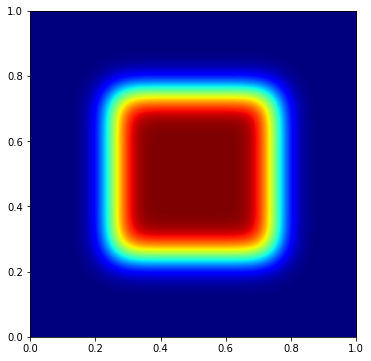

In [45]:
# Copy the current concentration from the device to the host
c = d_c.copy_to_host()

# Display the current concentration profile
fig = plt.figure(figsize = [6, 6])
plt.imshow(c,cmap='jet',extent=[0.0, 1.0, 0.0, 1.0]);

When testing this resulted in a saving of approximately 15%, despite the fact that we're not using all of the threads in a block to do computation. The saving on loads from global memory has more than offset that.

## Exercises

* How do these kernels perform relative to the corresponding CPU implementation? Use the Tinis GPU node to gather your benchmarks and remember to take averages excluding compilation.

* How does the benefit gained from using shared memory to eliminate redundant loads vary with the size of the grid and the number of timesteps simulated? I've been a bit lazy with my code, so you'll need to make sure all grid sizes are a multiple of both 32 and 30.

* (Advanced) How does the balance between use of shared memory and threads idle during computation change when moving from 2D to 3D?

* (Very advanced) Can you create a kernel for this problem which exploits the use of shared memory without leaving any threads idle during computation? 

---

## Atomic operations

Shared memory can also be used if wanting multiple threads to read/write to the same variable without going to global memory. This raises the issue of contention and possible race conditions.

Consider the following which sums over the elements in each row of an array

In [11]:
@cuda.jit
def sum_row(d_a, d_sum):
    """Given a device array a, calculate the sum over elements in each row."""

    # Get row and column of current element
    row = cuda.threadIdx.y    + cuda.blockIdx.y * cuda.blockDim.y
    column = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    
    if (row < d_a.shape[0]):
        if column == 0 :                   
            d_sum[row] = 0.0 # First thread in row initialises sum
    
    if (row < d_a.shape[0]):
        if column < d_a.shape[1]:
            #cuda.atomic.add(d_sum, row , d_a[row, column])
            d_sum[row] += d_a[row, column]

Let's test this on a trivial array

In [12]:
# Generate random 3 x 2 array
my_array = np.random.rand(3, 2)
my_array

array([[ 0.10631375,  0.76606422],
       [ 0.04819673,  0.24172434],
       [ 0.68878709,  0.6004742 ]])

In [13]:
# Calculate sum over elements in each row (axis = 1 means sum over columns)
np.sum(my_array, axis=1)

array([ 0.87237798,  0.28992107,  1.28926129])

Do the same calculation using our new kernel

In [14]:
# Copy data to device and create new array for output
d_my_array = cuda.to_device(my_array)
d_my_sum   = cuda.device_array(3, dtype=np.float64)

# Launch a single thread block of 2 x 3 threads
sum_row[(1, 1), (2, 3)](d_my_array, d_my_sum)

# Copy result back and print it
my_sum = d_my_sum.copy_to_host()
my_sum

array([ 0.76606422,  0.24172434,  0.6004742 ])

Panic - this hasn't given us the correct result. What could be wrong? 

The problem is a *race condition*. There is nothing stopping threads in columns other than column 0 from adding in their contribution to the sum before it has been initialised. 

Similarly thread A must read the current value of the sum before adding its own contribution. If another thread B changes the sum after A has read the old value, but before A writes the result of its sum, A will be working with a *stale* value and get the wrong result.

We can take steps to fix this...

In [15]:
@cuda.jit
def sum_row_v2(d_a, d_sum):
    """Given a device array a, calculate the sum over elements in each row."""

    # Get row and column of current element
    row = cuda.threadIdx.y    + cuda.blockIdx.y * cuda.blockDim.y
    column = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    
    if (row < d_a.shape[0]):
        if column == 0 :                   
            d_sum[row] = 0.0 # First thread in row initialises sum
    
    # No thread can pass this point until all threads reach this statement
    cuda.syncthreads()
    
    if (row < d_a.shape[0]):
        if column < d_a.shape[1]:
            
            # Add to element 'row' of array d_sum
            cuda.atomic.add(d_sum, row , d_a[row, column])

Here we've used an *atomic operation* - in this case the operation 'sum'. Atomics prevent more than one thread at a time being able to read/write from a particular memory location. They act like a thread lock. Other operations than sum are available. See [the documentation](https://numba.pydata.org/numba-doc/dev/cuda/intrinsics.html).

We've also use ```cuda.syncthreads()``` to ensure no thread writes to the sum before it is initialised.

Let's check that we get the correct answer this time...

In [16]:
# Copy data to device and create new array for output
d_my_array = cuda.to_device(my_array)
d_my_sum   = cuda.device_array(3, dtype=np.float64)

# Launch a single thread block of 2 x 3 threads
sum_row_v2[(1, 1), (2, 3)](d_my_array, d_my_sum)

# Copy result back and print it
my_sum = d_my_sum.copy_to_host()
my_sum

array([ 0.87237798,  0.28992107,  1.28926129])

Phew. Be aware that use of atomics slows code down drastically. They effectively serialise the operations they perform. 

We can also use atomics on shared memory if we want to reduce access to global memory, but we need to be aware that shared memory only persists for the lifetime of the thread block and so any result must be written back to global memory once computed.

In [17]:
@cuda.jit
def sum_row_v3(d_a, d_sum):
    """Given a device array a, calculate the sum over elements in each row."""

    # Get row and column of current element
    row = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    column = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    
    # Create shared memory array to use for summation
    sum_sh = cuda.shared.array(3, dtype=float64)
    
    if (row < d_a.shape[0]):
        if column == 0 :                   
            sum_sh[row] = 0.0 # First thread in row initialises sum

    cuda.syncthreads()
    
    if (row < d_a.shape[0]):
        if column < d_a.shape[1]:
            
            # Add to element 'row' of array sum_sh. Note that we 
            # don't need to read from global memory anymore
            cuda.atomic.add(sum_sh, row , d_a[row, column])
            
    cuda.syncthreads()
           
    # Write result to global memory
    if (row < d_a.shape[0]):        
        if column == 0 : d_sum[row] = sum_sh[row]

Let's check that this still works...

In [18]:
# Copy data to device and create new array for output
d_my_array = cuda.to_device(my_array)
d_my_sum   = cuda.device_array(3, dtype=np.float64)

# Launch a single thread block of 2 x 3 threads
sum_row_v3[(1, 1), (2, 3)](d_my_array, d_my_sum)

# Copy result back and print it
my_sum = d_my_sum.copy_to_host()
my_sum

array([ 0.87237798,  0.28992107,  1.28926129])

## Exercise

* The kernel used in ```sum_row_v3``` above will only work as advertised if the array we want to sum over fits within a single thread block. Create a new kernel which will work for arrays of any size and test your result against the sum method of a numpy array on the CPU.

---

## Constant memory

For our final example we'll do something a bit more substantial for which we might expect to see a significant benefit from using a GPU. Imagine we have a function of three variables $f(x,y,z)$ which is defined as a sum over Gaussians centered on $P$ different points $\{x_{i},y_{i},z_{i}\}$. We are only interested in the function between -10 and +10 in each direction.

$$f(x,y,z) = \sum_{i=1}^{P}A\exp\left\{-w\left[\left(x-x_{i}\right)^2+\left(y-y_{i}\right)^2+\left(z-z_{i}\right)^2\right]\right\}$$

Our goal is to integrate out (numerically) one of the dimensions and obtain a two-dimensional function

$$g(x,y) = \int_{-10}^{10}\exp\left[f(x,y,z)\right] dz.$$

To compute this function on a $N_{grid} \times N_{grid}$ mesh in the $x,y$ plane, we must perform the above integration over $z$ at each point. For simplicity we will integrate numerically over $N_{grid}$ points in the $z$ direction using the trapezoidal rule. We must therefore evaluate the function a total of $N_{grid}^3 $ times which quickly becomes expensive as the size of the grid increases.

Exactly this problem can arise in molecular simulation when attempting to create a two-dimensional probability density plot from a reconstructed free energy. For anyone intersted, $f(x,y,z)$ is a free energy reconstructed from the points $\{x_{i},y_{i},z_{i}\}$ visited during a molecular dynamics simulation. $x,y$ and $z$ are themselves functions of atomic coordinates, such as the end-to-end distance of a polymer, or the number of hydrogen bonds in a system. 

NOTE - if this code looks like the least pythonic thing you've ever seen there's a reason for that. It has been translated line by line from an existing C code I use in my reseach.

We'll start by running a C implementation of this code which runs on the CPU. The file ```quadrature_CPU.c``` should exist in the same directory you're running this notebook from.

In [99]:
import subprocess

# Compile - this is like "gcc quadrature_cpu.c -o quad_cpu -lm -O3" on the command line
subprocess.Popen(["gcc","quadrature_cpu.c","-o","quad_cpu","-lm", "-O3"]);

# Run, and capture output for printing
time_code = subprocess.Popen(["./quad_cpu"], stdout=subprocess.PIPE)
outstring = time_code.communicate()[0]
print(outstring.decode())

Time taken on CPU = 20.420000 seconds



First we need a function which evaluates $f(x,y,x)$.

In [19]:
import math as m

def func(x, y, z, d_points, count, height, width):
    """
    This function evaluates f(x,y,z)
    """
    
    tot = 0.0

    for i in range(P):
        arg  = (x-d_points[i,0])**2
        arg += (y-d_points[i,1])**2
        arg += (z-d_points[i,2])**2
        tot += A*m.exp(-w*arg)
    
    return tot

In [20]:
# Turn the above code into a device function
func_gpu = cuda.jit(device=True)(func)

The kernel we use will integrate over z for each x, y point in the grid.

In [69]:
@cuda.jit
def integrate1D(min_coord, max_coord, N, d_a, d_arrpoint, num_points, gauss_height, gauss_width):
    """
    This is our kernel. for a point on our two-dimension grid
    integrate over the function in the third dimension.
    kernels must be global, visible to the host and device.
    """
    
    # Which element on the 2D grid does this instance 
    # of the kernel need to compute?
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    if col < N and row < N:

        # Compute grid spacing and current x and y value
        delta = (max_coord - min_coord)/(N - 1.0)

        x     = min_coord + float(col) * delta
        y     = min_coord + float(row) * delta

        # Integrate along z using trapezoidal rule
        g_loc = 0.0
        z     = min_coord
        f     = func_gpu(x, y, z, d_arrpoint, num_points, gauss_height, gauss_width)
        p_old = m.exp(f)
        
        for k in range(1, N):
            z += delta
            f = func_gpu(x, y, z, d_arrpoint, num_points, gauss_height, gauss_width)
            p_new  = m.exp(f)
            g_loc += delta * 0.5 * (p_old + p_new)
            p_old  = p_new

        # Store at the appropriate location in g
        d_a[row, col] = g_loc

In [72]:
# Number of Gaussians
P = 500

# Number of points on the grid in each dimension
Ngrid = 128

# Width and height of Gaussians
A = 0.1; w = 0.2

# Extend of grid
grid_min = -10.0
grid_max =  10.0

# Create P random points in 3 dimension representing the Gaussian centres
np.random.seed(12072018)  # Make sure results are reproducible
points = (grid_max - grid_min) * np.random.rand(P, 3) + grid_min

# 32 x 32 threads in a block
threads_per_block = (32, 32)
blocks_per_grid = (Ngrid//32, Ngrid//32)

# Copy this to the device
d_points = cuda.to_device(points)

# Allocate memory on the device for the array holding g
d_g = cuda.device_array((Ngrid, Ngrid), dtype=np.float)

t1 = timer()

# Launch the kernel
integrate1D[blocks_per_grid, threads_per_block](grid_min, grid_max, Ngrid, d_g, d_points, P, A, w)

cuda.synchronize()  # make sure all threads finish before stopping timer

t2 = timer()

print("Calculation of g on the GPU took : ",1000.0*(t2-t1)," milliseconds.")

Calculation of g on the GPU took :  115.42464804369956  milliseconds.


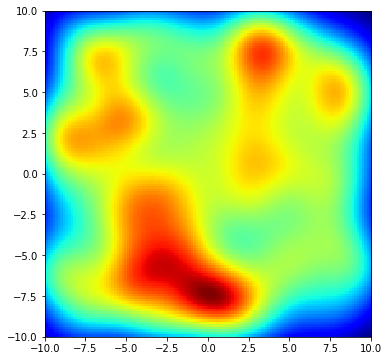

In [61]:
# Copy g to the host
g = d_g.copy_to_host()

# Show the result
plt.figure(figsize = [6, 6])
plt.imshow(g,cmap='jet', extent=[grid_min, grid_max, grid_min, grid_max]);

That should have been pretty speedy, but again we can do better. 

The array which holds the points needed by every call to ```func_gpu```, and that function is called many times by each thread. That's a lot of loads from global memory. Since these points don't change, we should use constant memory for these data instead.

Unfortunately, numba doesn't quite seem to support defining arrays in constant memory at runtime. So we'll have to illustrate the speedup from this using CUDA C code instead. 

In CUDA C, we would declare the points we want to store in constant memory as a global array (file scope).

```C
// Number of points P                                                                                                                                    
#define P 500

// Array of points at which Gaussians are located. This                                                                                                  
// is now a static array in constant memory                                                                                                              
__constant__ double points[3*P];
```

In the host code, we'll create the random points and copy them to the device.

```C
  // Allocate memory for points on the host                                                                                                              
  tmpPoints = (double *)malloc(3*P*sizeof(double));

  // Populate tmpPoints with random numbers between -10 and 10                                                                                           
  for (i=0;i<P;i++) {
    for (j=0;j<3;j++) {
      x = rand()/(double)RAND_MAX;
      tmpPoints[3*i+j] = gridMin + (gridMax-gridMin)*x;
    }
  }

  // Copy from tmpPoints on the host to points on the device                                                                                             
  cudaMemcpyToSymbol(points, tmpPoints, 3*P*sizeof(double));


```

We can test the speed of this implementation by compiling ```quadrature_gpu.cu``` with the Nvidia C compiler ```nvcc```.

In [103]:
# Compile 
subprocess.Popen(["nvcc","quadrature_gpu.cu","-o","quad_gpu","-lm", "-O3"]);

# Run, and capture output for printing
time_code = subprocess.Popen(["./quad_gpu"], stdout=subprocess.PIPE)
outstring = time_code.communicate()[0]
print(outstring.decode())

Found 2 CUDA devices in this system
Using device 0
Copied array of points to device memory
Using block grid dimensions of 4 by 4
Thread grid within a block is  32 by 32
Launching 16384 threads
Time taken on GPU = 70.000000 milliseconds



Note that the timer I'm using in my C code only has 1 millicond resolution. 

This is about twice as fast at the implementation in python above, but we can't guarantee that all of this is due to use of constant memory. 

## Exercises

* Numba hasn't let us reach quite the speed of the CUDA C implementation of this code due to the restrictions on constant memory. Can you think of a way of getting some speedup using shared memory instead? Test this and benchmark on the Tinis GPU nodes.

* (C programmers) is the CUDA C version still faster than our python version above if not using constant memory? I've made this easy for you by leaving some commented out lines in the source code.